In [ ]:
import numpy as np
from numpy.linalg import eigh, norm
import matplotlib.pyplot as plt

# Parameter configuration
d = 1000             # Feature dimension (fixed)
p = 4                # Subspace dimension
alpha = 6            # Sampling ratio α
n = int(d * alpha)   # Number of samples
alpha_c = p / 2      # Critical sampling ratio α_c = p / 2
np.random.seed(42)

# True signal subspace W_star
W_star = np.random.randn(d, p)
W_star, _ = np.linalg.qr(W_star)

# Input data matrix X ∈ ℝ^{n×d}
X = np.random.randn(n, d) / np.sqrt(d) 

# Latent variables Z = X @ W_star
Z = X @ W_star

# Link function: g(z) = ||z||² / p
def link_function(z):
    return np.sum(z**2, axis=1) / p

y = link_function(Z)

# Preprocessing function: T(y_i) = G(G + I)^(-1), where G = y_i * I_p
def compute_T_y_batch(y_batch):
    return np.array([
        p * (yi * np.eye(p)) @ np.linalg.inv(yi * np.eye(p) + np.eye(p)) for yi in y_batch
    ])

# Construct symmetric spectral matrix in batches
T_matrix = np.zeros((d * p, d * p))

batch_size = 500  # Mini-batch size for efficiency
for i in range(0, n, batch_size):
    X_batch = X[i:i+batch_size]                  # Shape: (B, d)
    y_batch = y[i:i+batch_size]                  # Shape: (B,)
    T_batch = compute_T_y_batch(y_batch)         # Shape: (B, p, p)

    for j in range(len(X_batch)):
        xxT = np.outer(X_batch[j], X_batch[j])   # ∈ ℝ^{d×d}
        T_y = T_batch[j]                         # ∈ ℝ^{p×p}
        T_matrix += np.kron(xxT, T_y)

T_matrix /= (n * d)  # Normalization

# Eigen-decomposition
eigvals, _ = eigh(T_matrix)


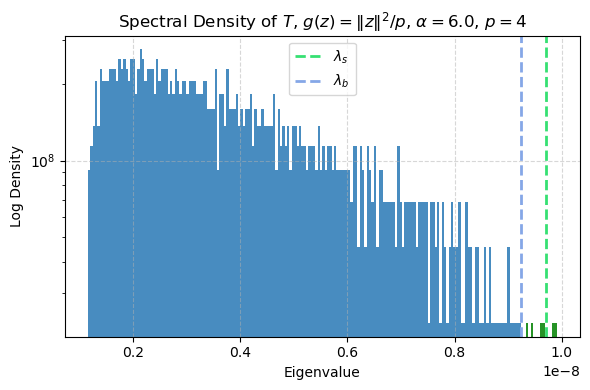

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os

# Required variables
# eigvals: array of eigenvalues (ascending order)
# alpha, p: sampling ratio and signal subspace dimension
lambda_s = 9.70161885e-09
lambda_b = 9.23452852e-9
alpha = 6.0
p = 4

# Output path and file name
save_path = r"./figures"
filename_base = f"spectrum_alpha{alpha}_p{p}"

# Create directory if it does not exist
os.makedirs(save_path, exist_ok=True)

# Color settings
bulk_color = '#2878B5'     # Bulk eigenvalues
signal_color = 'green'     # Signal eigenvalues

# Histogram of eigenvalues
hist, bin_edges = np.histogram(eigvals, bins=200, density=True)
bin_width = bin_edges[1] - bin_edges[0]
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# Identify bins containing the largest 24 eigenvalues (signal components)
eigvals_sorted = np.sort(eigvals)
signal_eigs = eigvals_sorted[-24:]  # Change to -4 for the top 4 eigenvalues
signal_bins = set(np.digitize(signal_eigs, bin_edges) - 1)

# Plot spectral density histogram
plt.figure(figsize=(6, 4))
for i in range(len(hist)):
    color = signal_color if i in signal_bins else bulk_color
    plt.bar(bin_centers[i], hist[i], width=bin_width, color=color, alpha=0.85)

# Add vertical reference lines for thresholds
plt.axvline(lambda_s, color='#36E072', linestyle='--', linewidth=2, label=r'$\lambda_s$')
plt.axvline(lambda_b, color='#85A7E7', linestyle='--', linewidth=2, label=r'$\lambda_b$')

# Axis scaling, labels, and style settings
plt.yscale('log')
plt.title(r"Spectral Density of $T$, $g(z) = \|z\|^2/p$, $\alpha = {:.1f}$, $p = {}$".format(alpha, p))
plt.xlabel("Eigenvalue")
plt.ylabel("Log Density")
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()

# Save figure in both PDF and PNG formats (publication-ready)
plt.savefig(os.path.join(save_path, filename_base + ".pdf"), dpi=300, bbox_inches='tight')
plt.savefig(os.path.join(save_path, filename_base + ".png"), dpi=300, bbox_inches='tight')

# Display the figure
plt.show()


In [ ]:
# Extract the top p eigenvectors corresponding to the largest eigenvalues
eigvals, eigvecs = eigh(T_matrix)
top_components = eigvecs[:, -p:]  # Shape: (d*p, p), top p eigen-directions

# Reshape block vectors into a d × p matrix
W_blocks = [top_components[i*d:(i+1)*d, :] for i in range(p)]  # Each block ∈ ℝ^{d×1}
W_avg = np.mean(W_blocks, axis=0)  # Averaged block matrix ∈ ℝ^{d×p}
from scipy.linalg import orth
W_hat = orth(W_avg)  # Orthonormalization: estimated subspace basis W_hat ∈ ℝ^{d×p}

# Evaluate Weak Recovery Score and Subspace Alignment Score
# True projection matrix
Q = W_star @ W_star.T
# Estimated projection matrix
P_hat = W_hat @ W_hat.T
# Weak recovery score = ||P_hat Q P_hat||_F² / Tr(Q)
M_hat = P_hat @ Q @ P_hat
weak_score = norm(M_hat, ord='fro')**2 / np.trace(Q)

# Subspace alignment score = mean cos² of principal angles
from numpy.linalg import svd
U_align, _, Vt_align = svd(W_star.T @ W_hat)
align_score = np.mean(np.diag(U_align @ Vt_align) ** 2)

print(f"Weak Recovery Score: {weak_score:.6f}")
print(f"Subspace Alignment Score: {align_score:.6f}")


Weak Recovery Score: 0.000047
Subspace Alignment Score: 0.342657
